In [ ]:
#### Unet  Model ######

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Total loaded images: 3251
Total loaded masks: 3251
Training set size: 2275
Validation set size: 488
Test set size: 488


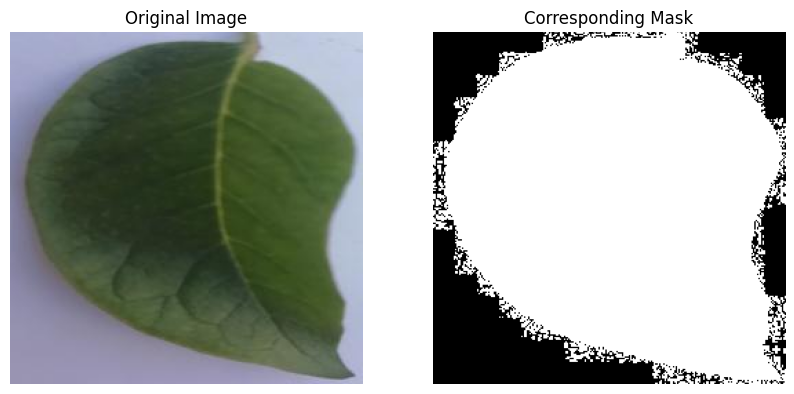

Epoch 1/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.5992 - loss: 0.6749 - val_accuracy: 0.5886 - val_loss: 0.6139
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 774ms/step - accuracy: 0.6055 - loss: 0.5905 - val_accuracy: 0.6786 - val_loss: 0.5411
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 774ms/step - accuracy: 0.6682 - loss: 0.5400 - val_accuracy: 0.6825 - val_loss: 0.5302
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 774ms/step - accuracy: 0.6852 - loss: 0.5297 - val_accuracy: 0.6948 - val_loss: 0.5472
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 775ms/step - accuracy: 0.7114 - loss: 0.5192 - val_accuracy: 0.7077 - val_loss: 0.5207
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 775ms/step - accuracy: 0.7303 - loss: 0.5029 - val_accuracy: 0.7066 - val_loss: 0.5140
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 776ms/step - accuracy: 0.7307 - loss: 0.4989 - val_accuracy: 0.7562 - val_loss: 0.4732
Epoch 8/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 776ms/step - accuracy: 0.7537 - loss: 0.4758 - va

In [2]:
def load_and_preprocess_data(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []
    sub_dirs = sorted(os.listdir(image_dir))
    for sub_dir in sub_dirs:
        sub_image_dir = os.path.join(image_dir, sub_dir)
        sub_mask_dir = os.path.join(mask_dir, sub_dir)
        image_filenames = sorted(os.listdir(sub_image_dir))
        mask_filenames = sorted(os.listdir(sub_mask_dir))
        assert len(image_filenames) == len(mask_filenames), f"Mismatch in number of images and masks in {sub_dir}."
        for img_filename, mask_filename in zip(image_filenames, mask_filenames):
            img_path = os.path.join(sub_image_dir, img_filename)
            mask_path = os.path.join(sub_mask_dir, mask_filename)

            img = load_img(img_path, target_size=target_size)
            mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')

            img_array = img_to_array(img) / 255.0  # Normalize image
            mask_array = img_to_array(mask).astype(np.int32).squeeze()

            # Convert mask to binary (foreground=1, background=0)
            mask_array = (mask_array > 0).astype(np.int32)

            images.append(img_array)
            masks.append(mask_array)

    images = np.array(images)
    masks = np.array(masks)

    masks = np.expand_dims(masks, axis=-1)

    return images, masks

def build_unet(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder: Contracting path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder: Expansive path
    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c4], axis=-1)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c3], axis=-1)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.UpSampling2D((2, 2))(c7)
    u8 = layers.concatenate([u8, c2], axis=-1)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.UpSampling2D((2, 2))(c8)
    u9 = layers.concatenate([u9, c1], axis=-1)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Binary segmentation

    model = models.Model(inputs, outputs)
    return model

image_dir = '/kaggle/input/originaldataset/Original'  # Path to original images
mask_dir = '/kaggle/input/maskdataset/Mask'      # Path to mask images

X, y = load_and_preprocess_data(image_dir, mask_dir)
print(f"Total loaded images: {len(X)}")
print(f"Total loaded masks: {len(y)}")

# Split data into training and validation sets
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Display one example image and its mask
def display_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap="gray")
    plt.title("Corresponding Mask")
    plt.axis("off")

    plt.show()

index = 15
display_image_and_mask(X_train[index], y_train[index])

# Build and compile the U-Net model
model_unet = build_unet(input_size=(256, 256, 3))
model_unet.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_unet.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))

# Save the trained model
#model.save('/kaggle/working/unet_binary_segmentation.h5')

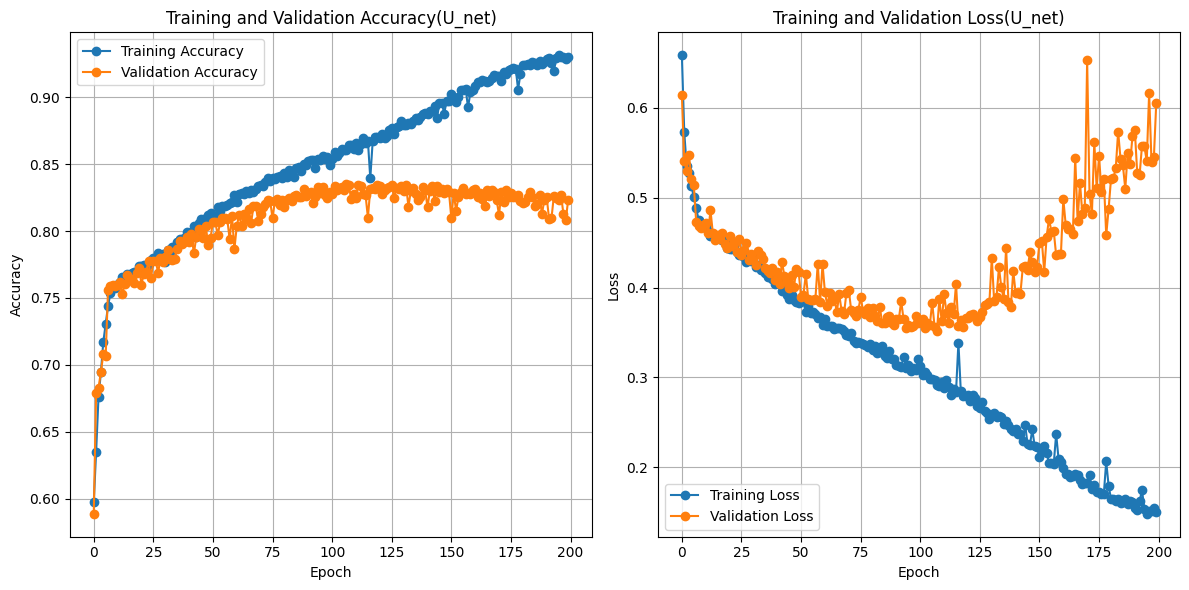

In [3]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
def plot_training_history(history):
    # Extract values for accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy(U_net)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss(U_net)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function after model training
plot_training_history(history)


In [4]:
print("Evaluating the model...")
loss, accuracy = model_unet.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Evaluating the model...
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.8218 - loss: 0.6162
Test Loss: 0.5718594789505005
Test Accuracy: 0.8284693360328674


In [5]:
val_loss, val_accuracy = model_unet.evaluate(X_val, y_val, batch_size=32)

print(f"Val Loss: {val_loss}")
print(f"Val Accuracy: {val_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.8287 - loss: 0.5872
Val Loss: 0.6057508587837219
Val Accuracy: 0.8234376907348633


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step
Classification Report:
                precision    recall  f1-score   support

Background (0)       0.87      0.85      0.86  19641244
Foreground (1)       0.77      0.80      0.78  12340324

      accuracy                           0.83  31981568
     macro avg       0.82      0.82      0.82  31981568
  weighted avg       0.83      0.83      0.83  31981568

Mean IoU: 0.6422
Dice Coefficient: 0.7821
Pixel Accuracy: 0.8285
Testing Accuracy: 82.85%


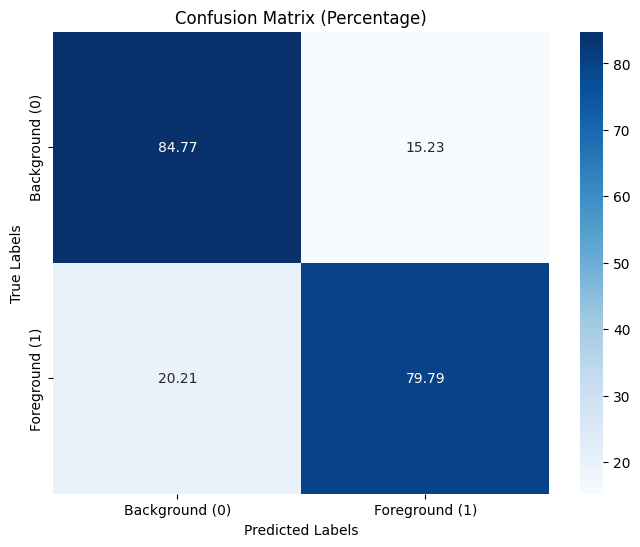

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def mean_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) != 0 else 0

def pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def compute_metrics_and_plot_confusion_matrix(model, test_images, test_masks):
    predictions = model.predict(test_images)
    predictions = np.squeeze(predictions, axis=-1)  # Ensure correct shape

    predicted_masks = (predictions > 0.5).astype(np.uint8)
    test_masks_binary = (test_masks > 0.5).astype(np.uint8)

    predicted_masks_flat = predicted_masks.flatten()
    test_masks_binary_flat = test_masks_binary.flatten()

    cm = confusion_matrix(test_masks_binary_flat, predicted_masks_flat)
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # Normalize per class

    print("Classification Report:")
    print(classification_report(test_masks_binary_flat, predicted_masks_flat, target_names=["Background (0)", "Foreground (1)"]))

    iou = mean_iou(test_masks_binary_flat, predicted_masks_flat)
    dice = dice_coefficient(test_masks_binary_flat, predicted_masks_flat)
    accuracy = pixel_accuracy(test_masks_binary_flat, predicted_masks_flat)
    correct_predictions = np.sum(test_masks_binary_flat == predicted_masks_flat)
    testing_accuracy = (correct_predictions / test_masks_binary_flat.size) * 100

    print(f"Mean IoU: {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Testing Accuracy: {testing_accuracy:.2f}%")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=["Background (0)", "Foreground (1)"],
                yticklabels=["Background (0)", "Foreground (1)"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Percentage)")
    plt.show()
    
compute_metrics_and_plot_confusion_matrix(model_unet, X_test, y_test)

In [6]:
import pickle

with open('/kaggle/working/model_unet_pld.pkl', 'wb') as file:
    pickle.dump(model_unet, file)


In [ ]:
## Deeplab #####

Total loaded images: 3251
Total loaded masks: 3251
Training set size: 2275
Validation set size: 488
Test set size: 488


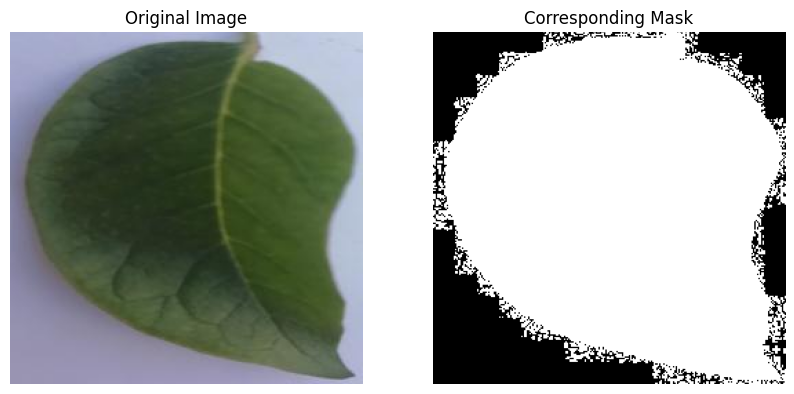

Epoch 1/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 437ms/step - accuracy: 0.5375 - loss: 0.6882 - val_accuracy: 0.5903 - val_loss: 0.6563
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.6087 - loss: 0.6374 - val_accuracy: 0.6519 - val_loss: 0.5852
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.6553 - loss: 0.5766 - val_accuracy: 0.6705 - val_loss: 0.5594
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.6678 - loss: 0.5561 - val_accuracy: 0.6810 - val_loss: 0.5492
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.6823 - loss: 0.5467 - val_accuracy: 0.7005 - val_loss: 0.5351
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.7120 - loss: 0.5314 - val_accuracy: 0.7170 - val_loss: 0.5219
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.7264 - loss: 0.5182 - val_accuracy: 0.7318 - val_loss: 0.5169
Epoch 8/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.7383 - loss: 0.5080 - 

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Function to load and preprocess data
def load_and_preprocess_data(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []
    sub_dirs = sorted(os.listdir(image_dir))
    for sub_dir in sub_dirs:
        sub_image_dir = os.path.join(image_dir, sub_dir)
        sub_mask_dir = os.path.join(mask_dir, sub_dir)
        image_filenames = sorted(os.listdir(sub_image_dir))
        mask_filenames = sorted(os.listdir(sub_mask_dir))
        assert len(image_filenames) == len(mask_filenames), f"Mismatch in number of images and masks in {sub_dir}."
        for img_filename, mask_filename in zip(image_filenames, mask_filenames):
            img_path = os.path.join(sub_image_dir, img_filename)
            mask_path = os.path.join(sub_mask_dir, mask_filename)

            img = load_img(img_path, target_size=target_size)
            mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')

            img_array = img_to_array(img) / 255.0  # Normalize image
            mask_array = img_to_array(mask).astype(np.int32).squeeze()

            # Convert mask to binary (foreground=1, background=0)
            mask_array = (mask_array > 0).astype(np.int32)

            images.append(img_array)
            masks.append(mask_array)

    images = np.array(images)
    masks = np.array(masks)

    # Add channel dimension to masks (required for binary segmentation)
    masks = np.expand_dims(masks, axis=-1)

    return images, masks

# DeepLab Model Definition
def build_deeplab(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Base Feature Extractor (Encoder)
    base_model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
    ])

    x = base_model(inputs)

    # Atrous Spatial Pyramid Pooling (ASPP)
    aspp1 = layers.Conv2D(256, (1, 1), dilation_rate=1, activation='relu', padding='same')(x)
    aspp2 = layers.Conv2D(256, (3, 3), dilation_rate=6, activation='relu', padding='same')(x)
    aspp3 = layers.Conv2D(256, (3, 3), dilation_rate=12, activation='relu', padding='same')(x)
    aspp4 = layers.Conv2D(256, (3, 3), dilation_rate=18, activation='relu', padding='same')(x)

    aspp = layers.concatenate([aspp1, aspp2, aspp3, aspp4], axis=-1)
    aspp = layers.Conv2D(256, (1, 1), activation='relu', padding='same')(aspp)

    # Decoder
    decoder = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(aspp)
    decoder = layers.UpSampling2D((2, 2))(decoder)
    decoder = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)
    decoder = layers.UpSampling2D((2, 2))(decoder)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(decoder)

    model = models.Model(inputs, outputs)
    return model

# Load and preprocess data
image_dir = '/kaggle/input/originaldataset/Original'  # Path to original images
mask_dir = '/kaggle/input/maskdataset/Mask'      # Path to mask images

X, y = load_and_preprocess_data(image_dir, mask_dir)
print(f"Total loaded images: {len(X)}")
print(f"Total loaded masks: {len(y)}")

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Display one example image and its mask
def display_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap="gray")
    plt.title("Corresponding Mask")
    plt.axis("off")

    plt.show()

index = 15
display_image_and_mask(X_train[index], y_train[index])

# Build and compile the DeepLab model
model_deeplab = build_deeplab(input_size=(256, 256, 3))
model_deeplab.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_deeplab.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))

# Save the trained model


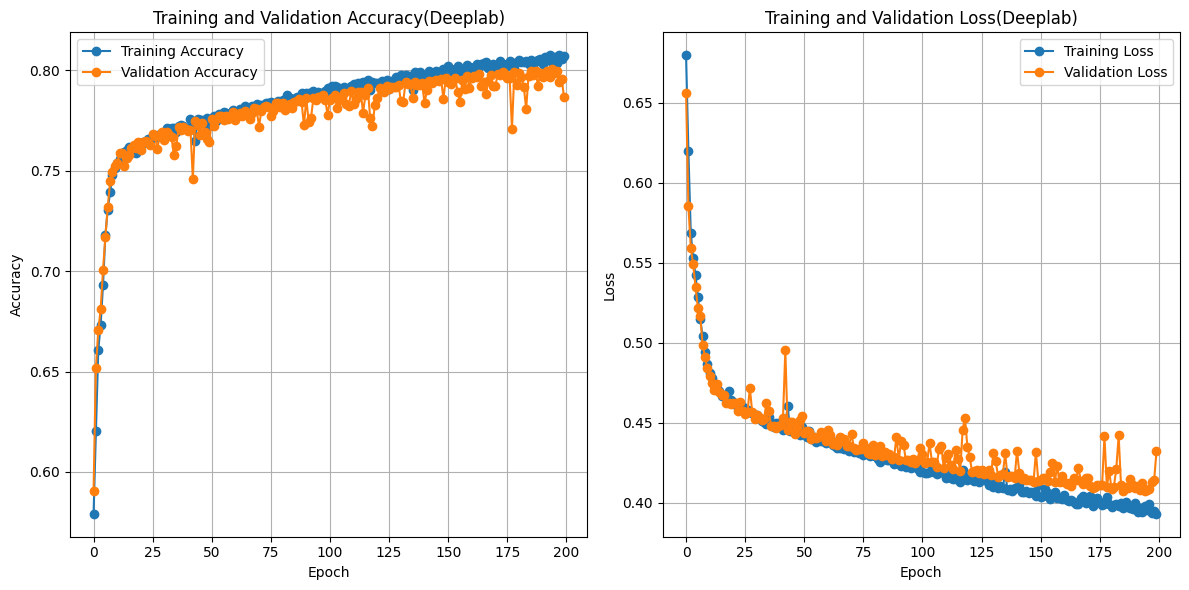

In [2]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
def plot_training_history(history):
    # Extract values for accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy(Deeplab)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss(Deeplab)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function after model training
plot_training_history(history)


In [3]:
print("Evaluating the model...")
loss, accuracy = model_deeplab.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Evaluating the model...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7765 - loss: 0.4483
Test Loss: 0.4379228353500366
Test Accuracy: 0.780947208404541


In [4]:
val_loss, val_accuracy = model_deeplab.evaluate(X_val, y_val, batch_size=32)

print(f"Val Loss: {val_loss}")
print(f"Val Accuracy: {val_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7874 - loss: 0.4295
Val Loss: 0.43222081661224365
Val Accuracy: 0.7868589758872986


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step
Classification Report:
                precision    recall  f1-score   support

Background (0)       0.77      0.93      0.84  19641244
Foreground (1)       0.83      0.55      0.66  12340324

      accuracy                           0.78  31981568
     macro avg       0.80      0.74      0.75  31981568
  weighted avg       0.79      0.78      0.77  31981568

Mean IoU: 0.4914
Dice Coefficient: 0.6590
Pixel Accuracy: 0.7809
Testing Accuracy: 78.09%


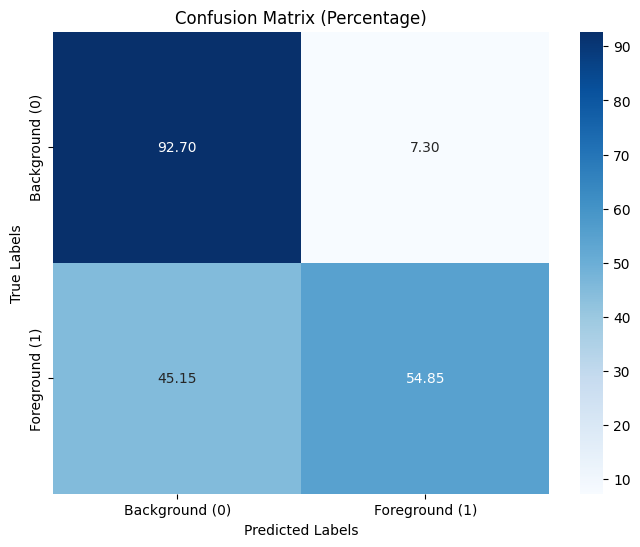

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def mean_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) != 0 else 0

def pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def compute_metrics_and_plot_confusion_matrix(model, test_images, test_masks):
    predictions = model.predict(test_images)
    predictions = np.squeeze(predictions, axis=-1)  # Ensure correct shape

    predicted_masks = (predictions > 0.5).astype(np.uint8)
    test_masks_binary = (test_masks > 0.5).astype(np.uint8)

    predicted_masks_flat = predicted_masks.flatten()
    test_masks_binary_flat = test_masks_binary.flatten()

    cm = confusion_matrix(test_masks_binary_flat, predicted_masks_flat)
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # Normalize per class

    print("Classification Report:")
    print(classification_report(test_masks_binary_flat, predicted_masks_flat, target_names=["Background (0)", "Foreground (1)"]))

    iou = mean_iou(test_masks_binary_flat, predicted_masks_flat)
    dice = dice_coefficient(test_masks_binary_flat, predicted_masks_flat)
    accuracy = pixel_accuracy(test_masks_binary_flat, predicted_masks_flat)
    correct_predictions = np.sum(test_masks_binary_flat == predicted_masks_flat)
    testing_accuracy = (correct_predictions / test_masks_binary_flat.size) * 100

    print(f"Mean IoU: {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Testing Accuracy: {testing_accuracy:.2f}%")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=["Background (0)", "Foreground (1)"],
                yticklabels=["Background (0)", "Foreground (1)"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Percentage)")
    plt.show()
    
compute_metrics_and_plot_confusion_matrix(model_deeplab, X_test, y_test)

In [6]:
import pickle

with open('/kaggle/working/model_deeplab_pld.pkl', 'wb') as file:
    pickle.dump(model_deeplab, file)


In [ ]:
######## Segnet ######

Total loaded images: 3251
Total loaded masks: 3251
Training set size: 2275
Validation set size: 488
Test set size: 488


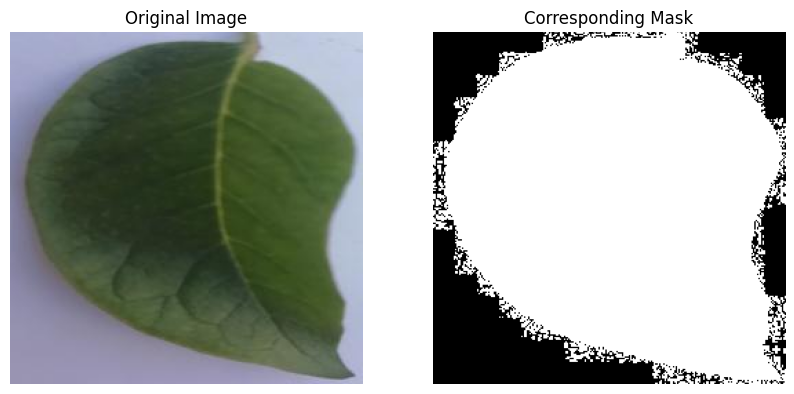

Epoch 1/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.5962 - loss: 0.6803 - val_accuracy: 0.5886 - val_loss: 0.6352
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 832ms/step - accuracy: 0.6201 - loss: 0.5961 - val_accuracy: 0.6716 - val_loss: 0.5498
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 832ms/step - accuracy: 0.6771 - loss: 0.5422 - val_accuracy: 0.6934 - val_loss: 0.5593
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 832ms/step - accuracy: 0.7081 - loss: 0.5290 - val_accuracy: 0.7087 - val_loss: 0.5317
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 833ms/step - accuracy: 0.7211 - loss: 0.5146 - val_accuracy: 0.7321 - val_loss: 0.5061
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 833ms/step - accuracy: 0.7392 - loss: 0.4997 - val_accuracy: 0.7348 - val_loss: 0.5121
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 834ms/step - accuracy: 0.7448 - loss: 0.4894 - val_accuracy: 0.7548 - val_loss: 0.4745
Epoch 8/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 833ms/step - accuracy: 0.7532 - loss: 0.4782 - va

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Function to load and preprocess data
def load_and_preprocess_data(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []
    sub_dirs = sorted(os.listdir(image_dir))
    for sub_dir in sub_dirs:
        sub_image_dir = os.path.join(image_dir, sub_dir)
        sub_mask_dir = os.path.join(mask_dir, sub_dir)
        image_filenames = sorted(os.listdir(sub_image_dir))
        mask_filenames = sorted(os.listdir(sub_mask_dir))
        assert len(image_filenames) == len(mask_filenames), f"Mismatch in number of images and masks in {sub_dir}."
        for img_filename, mask_filename in zip(image_filenames, mask_filenames):
            img_path = os.path.join(sub_image_dir, img_filename)
            mask_path = os.path.join(sub_mask_dir, mask_filename)

            img = load_img(img_path, target_size=target_size)
            mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')

            img_array = img_to_array(img) / 255.0  # Normalize image
            mask_array = img_to_array(mask).astype(np.int32).squeeze()

            # Convert mask to binary (foreground=1, background=0)
            mask_array = (mask_array > 0).astype(np.int32)

            images.append(img_array)
            masks.append(mask_array)

    images = np.array(images)
    masks = np.array(masks)

    # Add channel dimension to masks (required for binary segmentation)
    masks = np.expand_dims(masks, axis=-1)

    return images, masks

# SegNet Model Definition
def build_segnet(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u4 = layers.UpSampling2D((2, 2))(c5)
    u4 = layers.Concatenate()([u4, c4])  # Skip connection
    u4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
    
    u3 = layers.UpSampling2D((2, 2))(u4)
    u3 = layers.Concatenate()([u3, c3])  # Skip connection
    u3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    
    u2 = layers.UpSampling2D((2, 2))(u3)
    u2 = layers.Concatenate()([u2, c2])  # Skip connection
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    
    u1 = layers.UpSampling2D((2, 2))(u2)
    u1 = layers.Concatenate()([u1, c1])  # Skip connection
    u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u1)  # Binary segmentation

    model = models.Model(inputs, outputs)
    return model

# Load and preprocess data
image_dir = '/kaggle/input/originaldataset/Original'  # Path to original images
mask_dir = '/kaggle/input/maskdataset/Mask'      # Path to mask images

X, y = load_and_preprocess_data(image_dir, mask_dir)
print(f"Total loaded images: {len(X)}")
print(f"Total loaded masks: {len(y)}")

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Display one example image and its mask
def display_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap="gray")
    plt.title("Corresponding Mask")
    plt.axis("off")

    plt.show()

index = 15
display_image_and_mask(X_train[index], y_train[index])

# Build and compile the SegNet model
model_segnet = build_segnet(input_size=(256, 256, 3))
model_segnet.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_segnet.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))

# Save the trained model
#model.save('/kaggle/working/segnet_binary_segmentation.h5')


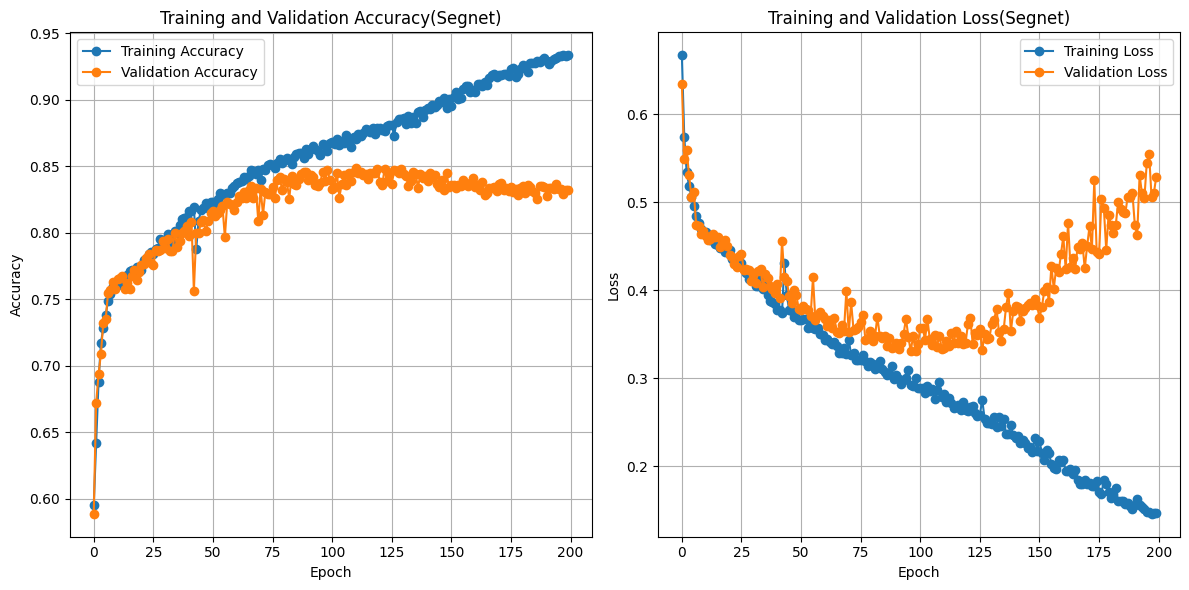

In [2]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
def plot_training_history(history):
    # Extract values for accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy(Segnet)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss(Segnet)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function after model training
plot_training_history(history)


In [3]:
print("Evaluating the model...")
loss, accuracy = model_segnet.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Evaluating the model...
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.8333 - loss: 0.5448
Test Loss: 0.516547679901123
Test Accuracy: 0.8362616896629333


In [5]:
val_loss, val_accuracy = model_segnet.evaluate(X_val, y_val, batch_size=32)

print(f"Val Loss: {val_loss}")
print(f"Val Accuracy: {val_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.8389 - loss: 0.5025
Val Loss: 0.5294212698936462
Val Accuracy: 0.8324096202850342


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step
Classification Report:
                precision    recall  f1-score   support

Background (0)       0.86      0.87      0.87  19641244
Foreground (1)       0.79      0.78      0.79  12340324

      accuracy                           0.84  31981568
     macro avg       0.83      0.83      0.83  31981568
  weighted avg       0.84      0.84      0.84  31981568

Mean IoU: 0.6488
Dice Coefficient: 0.7870
Pixel Accuracy: 0.8363
Testing Accuracy: 83.63%


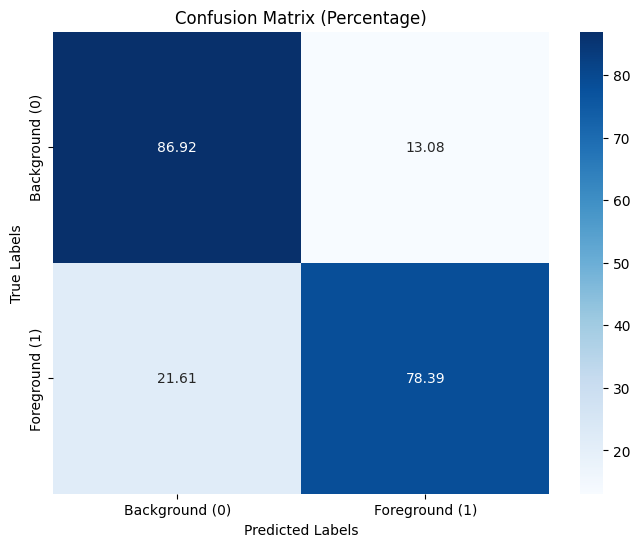

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def mean_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) != 0 else 0

def pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def compute_metrics_and_plot_confusion_matrix(model, test_images, test_masks):
    predictions = model.predict(test_images)
    predictions = np.squeeze(predictions, axis=-1)  # Ensure correct shape

    predicted_masks = (predictions > 0.5).astype(np.uint8)
    test_masks_binary = (test_masks > 0.5).astype(np.uint8)

    predicted_masks_flat = predicted_masks.flatten()
    test_masks_binary_flat = test_masks_binary.flatten()

    cm = confusion_matrix(test_masks_binary_flat, predicted_masks_flat)
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # Normalize per class

    print("Classification Report:")
    print(classification_report(test_masks_binary_flat, predicted_masks_flat, target_names=["Background (0)", "Foreground (1)"]))

    iou = mean_iou(test_masks_binary_flat, predicted_masks_flat)
    dice = dice_coefficient(test_masks_binary_flat, predicted_masks_flat)
    accuracy = pixel_accuracy(test_masks_binary_flat, predicted_masks_flat)
    correct_predictions = np.sum(test_masks_binary_flat == predicted_masks_flat)
    testing_accuracy = (correct_predictions / test_masks_binary_flat.size) * 100

    print(f"Mean IoU: {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Testing Accuracy: {testing_accuracy:.2f}%")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=["Background (0)", "Foreground (1)"],
                yticklabels=["Background (0)", "Foreground (1)"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Percentage)")
    plt.show()
    
compute_metrics_and_plot_confusion_matrix(model_segnet, X_test, y_test)

In [6]:
import pickle

with open('/kaggle/working/model_segnet_pld.pkl', 'wb') as file:
    pickle.dump(model_segnet, file)


In [ ]:
####### FCN ######

Total loaded images: 3251
Total loaded masks: 3251
Training set size: 2275
Validation set size: 488
Test set size: 488


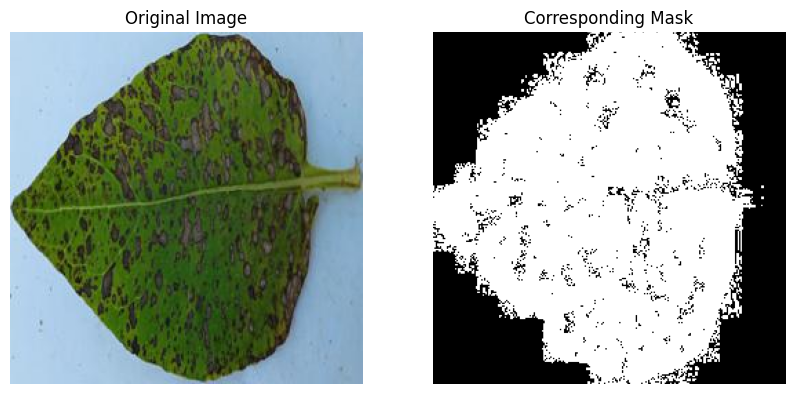

Epoch 1/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 100s 871ms/step - accuracy: 0.6053 - loss: 0.6721 - val_accuracy: 0.5886 - val_loss: 0.6582
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 556ms/step - accuracy: 0.5952 - loss: 0.6499 - val_accuracy: 0.5886 - val_loss: 0.6312
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 557ms/step - accuracy: 0.6106 - loss: 0.6089 - val_accuracy: 0.6511 - val_loss: 0.5726
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 557ms/step - accuracy: 0.6671 - loss: 0.5596 - val_accuracy: 0.6907 - val_loss: 0.5457
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 558ms/step - accuracy: 0.6931 - loss: 0.5429 - val_accuracy: 0.7038 - val_loss: 0.5314
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 556ms/step - accuracy: 0.7087 - loss: 0.5272 - val_accuracy: 0.7119 - val_loss: 0.5205
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 557ms/step - accuracy: 0.7152 - loss: 0.5200 - val_accuracy: 0.7188 - val_loss: 0.5128
Epoch 8/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 557ms/step - accuracy: 0.7211 - loss: 0.5120 -

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_and_preprocess_data(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []
    sub_dirs = sorted(os.listdir(image_dir))
    for sub_dir in sub_dirs:
        sub_image_dir = os.path.join(image_dir, sub_dir)
        sub_mask_dir = os.path.join(mask_dir, sub_dir)
        image_filenames = sorted(os.listdir(sub_image_dir))
        mask_filenames = sorted(os.listdir(sub_mask_dir))
        assert len(image_filenames) == len(mask_filenames), f"Mismatch in number of images and masks in {sub_dir}."
        for img_filename, mask_filename in zip(image_filenames, mask_filenames):
            img_path = os.path.join(sub_image_dir, img_filename)
            mask_path = os.path.join(sub_mask_dir, mask_filename)

            img = load_img(img_path, target_size=target_size)
            mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')

            img_array = img_to_array(img) / 255.0  # Normalize image
            mask_array = img_to_array(mask).astype(np.int32).squeeze()

            # Convert mask to binary (foreground=1, background=0)
            mask_array = (mask_array > 0).astype(np.int32)

            images.append(img_array)
            masks.append(mask_array)

    images = np.array(images)
    masks = np.array(masks)
    masks = np.expand_dims(masks, axis=-1)

    return images, masks

def build_fcn(input_shape=(256, 256, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder (VGG-like)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2), strides=(2, 2))(c1)  # 128x128

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2), strides=(2, 2))(c2)  # 64x64

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2), strides=(2, 2))(c3)  # 32x32

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2), strides=(2, 2))(c4)  # 16x16

    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (Upsampling + Skip Connections)
    u4 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(c5)  # 32x32
    u4 = layers.Concatenate()([u4, c4])  # Skip connection

    u3 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(u4)  # 64x64
    u3 = layers.Concatenate()([u3, c3])  # Skip connection

    u2 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(u3)  # 128x128
    u2 = layers.Concatenate()([u2, c2])  # Skip connection

    u1 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(u2)  # 256x256
    u1 = layers.Concatenate()([u1, c1])  # Skip connection

    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')(u1)  # Binary segmentation

    model = models.Model(inputs, outputs)
    return model

# Instantiate the model
fcn_model = build_fcn()
image_dir = '/kaggle/input/originaldataset/Original'  # Path to original images
mask_dir = '/kaggle/input/maskdataset/Mask'      # Path to mask images

X, y = load_and_preprocess_data(image_dir, mask_dir)
print(f"Total loaded images: {len(X)}")
print(f"Total loaded masks: {len(y)}")

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

def display_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap="gray")
    plt.title("Corresponding Mask")
    plt.axis("off")

    plt.show()

index = 17
display_image_and_mask(X_train[index], y_train[index])

# Build and compile the SegNet model
model_fcn = build_fcn(input_shape=(256, 256, 3))
model_fcn.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_fcn.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))


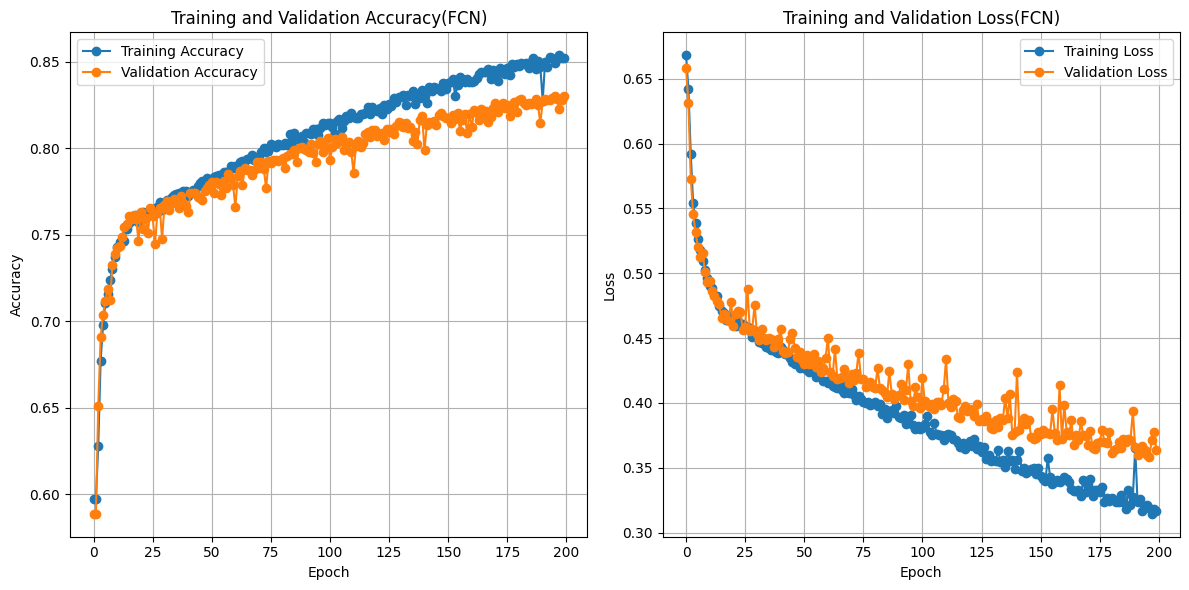

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
def plot_training_history(history):
    # Extract values for accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy(FCN)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss(FCN)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function after model training
plot_training_history(history)


In [3]:
import pickle

with open('/kaggle/working/model_fcn_pld.pkl', 'wb') as file:
    pickle.dump(model_fcn, file)

In [4]:
print("Evaluating the model...")
loss, accuracy = model_fcn.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Evaluating the model...
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.8311 - loss: 0.3676
Test Loss: 0.35598257184028625
Test Accuracy: 0.8361214399337769


In [5]:
val_loss, val_accuracy = model_fcn.evaluate(X_val, y_val, batch_size=32)

print(f"Val Loss: {val_loss}")
print(f"Val Accuracy: {val_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.8368 - loss: 0.3461
Val Loss: 0.3634842038154602
Val Accuracy: 0.8302913904190063


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step
Classification Report:
                precision    recall  f1-score   support

Background (0)       0.85      0.88      0.87  19641244
Foreground (1)       0.80      0.76      0.78  12340324

      accuracy                           0.84  31981568
     macro avg       0.83      0.82      0.83  31981568
  weighted avg       0.84      0.84      0.84  31981568

Mean IoU: 0.6418
Dice Coefficient: 0.7819
Pixel Accuracy: 0.8361
Testing Accuracy: 83.61%


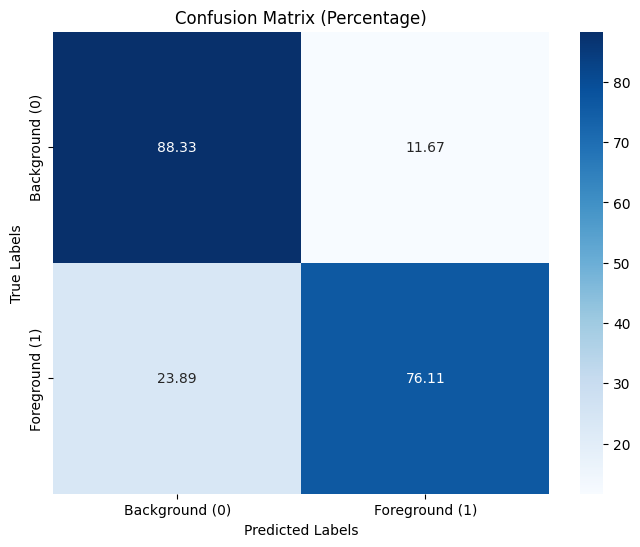

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def mean_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) != 0 else 0

def pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def compute_metrics_and_plot_confusion_matrix(model, test_images, test_masks):
    predictions = model.predict(test_images)
    predictions = np.squeeze(predictions, axis=-1)  # Ensure correct shape

    predicted_masks = (predictions > 0.5).astype(np.uint8)
    test_masks_binary = (test_masks > 0.5).astype(np.uint8)

    predicted_masks_flat = predicted_masks.flatten()
    test_masks_binary_flat = test_masks_binary.flatten()

    cm = confusion_matrix(test_masks_binary_flat, predicted_masks_flat)
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # Normalize per class

    print("Classification Report:")
    print(classification_report(test_masks_binary_flat, predicted_masks_flat, target_names=["Background (0)", "Foreground (1)"]))

    iou = mean_iou(test_masks_binary_flat, predicted_masks_flat)
    dice = dice_coefficient(test_masks_binary_flat, predicted_masks_flat)
    accuracy = pixel_accuracy(test_masks_binary_flat, predicted_masks_flat)
    correct_predictions = np.sum(test_masks_binary_flat == predicted_masks_flat)
    testing_accuracy = (correct_predictions / test_masks_binary_flat.size) * 100

    print(f"Mean IoU: {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Testing Accuracy: {testing_accuracy:.2f}%")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=["Background (0)", "Foreground (1)"],
                yticklabels=["Background (0)", "Foreground (1)"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Percentage)")
    plt.show()
    
compute_metrics_and_plot_confusion_matrix(model_fcn, X_test, y_test)

In [ ]:
###### Load Image and Dataset #######

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
def load_and_preprocess_data(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []
    sub_dirs = sorted(os.listdir(image_dir))
    for sub_dir in sub_dirs:
        sub_image_dir = os.path.join(image_dir, sub_dir)
        sub_mask_dir = os.path.join(mask_dir, sub_dir)
        image_filenames = sorted(os.listdir(sub_image_dir))
        mask_filenames = sorted(os.listdir(sub_mask_dir))
        assert len(image_filenames) == len(mask_filenames), f"Mismatch in number of images and masks in {sub_dir}."
        for img_filename, mask_filename in zip(image_filenames, mask_filenames):
            img_path = os.path.join(sub_image_dir, img_filename)
            mask_path = os.path.join(sub_mask_dir, mask_filename)

            img = load_img(img_path, target_size=target_size)
            mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')

            img_array = img_to_array(img) / 255.0  # Normalize image
            mask_array = img_to_array(mask).astype(np.int32).squeeze()

            # Convert mask to binary (foreground=1, background=0)
            mask_array = (mask_array > 0).astype(np.int32)

            images.append(img_array)
            masks.append(mask_array)

    images = np.array(images)
    masks = np.array(masks)

    # Add channel dimension to masks (required for binary segmentation)
    masks = np.expand_dims(masks, axis=-1)

    return images, masks


image_dir = '/kaggle/input/originaldataset/Original'  # Path to original images
mask_dir = '/kaggle/input/maskdataset/Mask'      # Path to mask images

X, y = load_and_preprocess_data(image_dir, mask_dir)
print(f"Total loaded images: {len(X)}")
print(f"Total loaded masks: {len(y)}")

# Split data into training and validation sets
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Total loaded images: 3251
Total loaded masks: 3251
Training set size: 2275
Validation set size: 488
Test set size: 488


In [ ]:
#### Load Unet Model ########

In [4]:
import pickle

model_path = "/kaggle/input/unet_model_pld/other/default/1/model_unet_pld.pkl"

# Load the pickled model
with open(model_path, 'rb') as file:
    unet_model = pickle.load(file)

print("Model loaded successfully!")


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


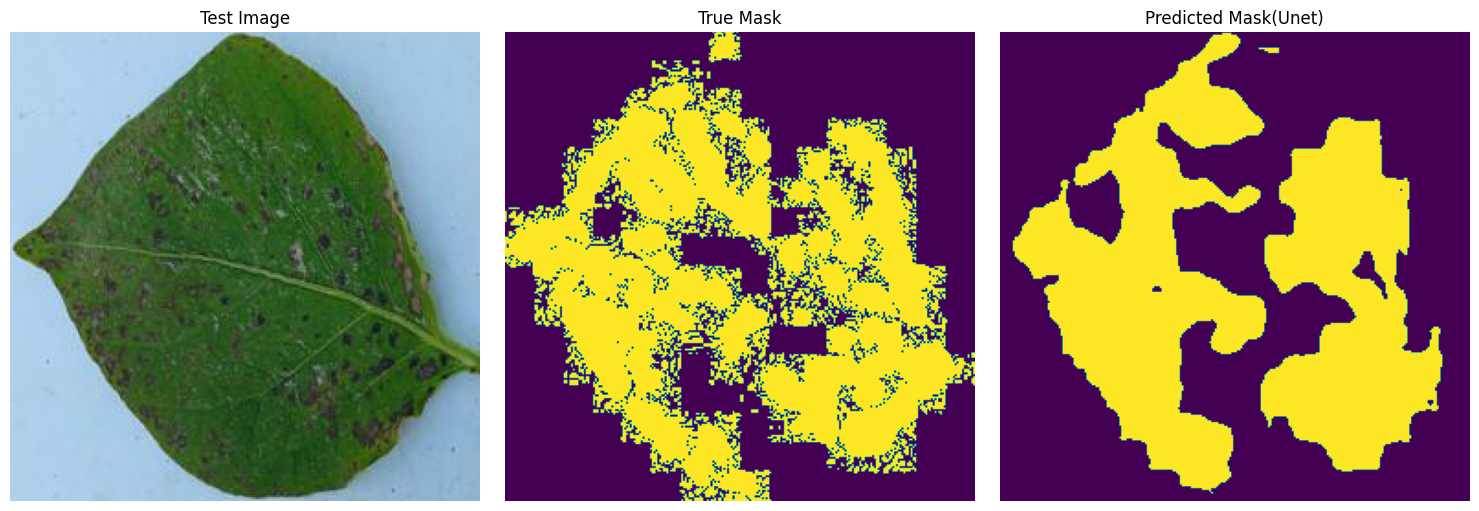

In [9]:
import random

def test_random_image(model, X_test, y_test):
    # Select a random index
    #random_index = random.randint(0, len(X_test) - 1)
    random_index = 35
    
    # Get the test image and true mask
    test_image = X_test[random_index]
    true_mask = y_test[random_index]
    
    # Model prediction (add batch dimension as the model expects it)
    predicted_mask = model.predict(test_image[np.newaxis, ...])[0]
    
    # Threshold the predicted mask (binary segmentation: threshold at 0.5)
    predicted_mask = (predicted_mask > 0.5).astype(np.int32).squeeze()
    
    # Visualize the test image, true mask, and predicted mask
    plt.figure(figsize=(15, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title("Test Image")
    plt.axis("off")
    
    # True Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze())
    plt.title("True Mask")
    plt.axis("off")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title("Predicted Mask(Unet)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Test a random image
test_random_image(unet_model, X_test, y_test)

In [5]:
##### Load DeepLab Model #######

In [11]:
import pickle

model_path = "/kaggle/input/model_deeplab_pld/other/default/1/model_deeplab_pld.pkl"

# Load the pickled model
with open(model_path, 'rb') as file:
    deeplab_model = pickle.load(file)

print("Model loaded successfully!")


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


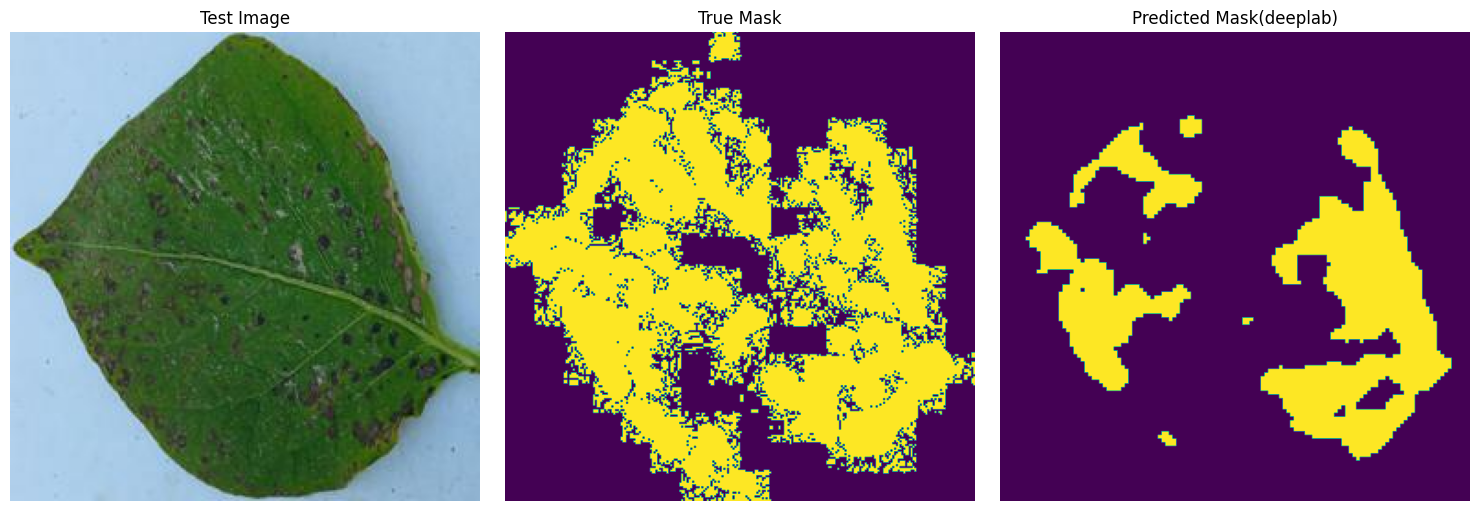

In [17]:
import random

def test_random_image(model, X_test, y_test):
    # Select a random index
    #random_index = random.randint(0, len(X_test) - 1)
    random_index = 35
    
    # Get the test image and true mask
    test_image = X_test[random_index]
    true_mask = y_test[random_index]
    
    # Model prediction (add batch dimension as the model expects it)
    predicted_mask = model.predict(test_image[np.newaxis, ...])[0]
    
    # Threshold the predicted mask (binary segmentation: threshold at 0.5)
    predicted_mask = (predicted_mask > 0.5).astype(np.int32).squeeze()
    
    # Visualize the test image, true mask, and predicted mask
    plt.figure(figsize=(15, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title("Test Image")
    plt.axis("off")
    
    # True Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze())
    plt.title("True Mask")
    plt.axis("off")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title("Predicted Mask(deeplab)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Test a random image
test_random_image(deeplab_model, X_test, y_test)

In [ ]:
##### Load FCN Model ######

In [13]:
import pickle

model_path = "/kaggle/input/model_fcn_pld/other/default/1/model_fcn_pld.pkl"

# Load the pickled model
with open(model_path, 'rb') as file:
    fcn_model = pickle.load(file)

print("Model loaded successfully!")


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


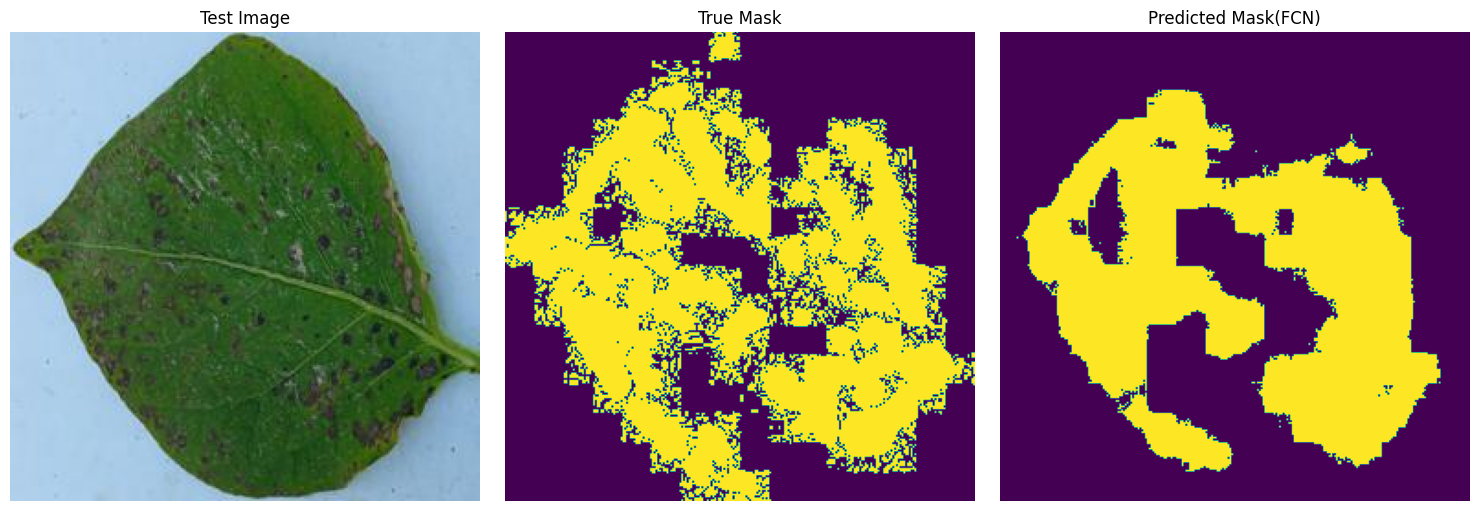

In [18]:
import random

def test_random_image(model, X_test, y_test):
    # Select a random index
    #random_index = random.randint(0, len(X_test) - 1)
    random_index = 35
    
    # Get the test image and true mask
    test_image = X_test[random_index]
    true_mask = y_test[random_index]
    
    # Model prediction (add batch dimension as the model expects it)
    predicted_mask = model.predict(test_image[np.newaxis, ...])[0]
    
    # Threshold the predicted mask (binary segmentation: threshold at 0.5)
    predicted_mask = (predicted_mask > 0.5).astype(np.int32).squeeze()
    
    # Visualize the test image, true mask, and predicted mask
    plt.figure(figsize=(15, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title("Test Image")
    plt.axis("off")
    
    # True Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze())
    plt.title("True Mask")
    plt.axis("off")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title("Predicted Mask(FCN)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Test a random image
test_random_image(fcn_model, X_test, y_test)

In [ ]:
###### Load Segnet Model #######3

In [15]:
import pickle

model_path = "/kaggle/input/model_segnet_pld/other/default/1/model_segnet_pld.pkl"

# Load the pickled model
with open(model_path, 'rb') as file:
    segnet_model = pickle.load(file)

print("Model loaded successfully!")


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


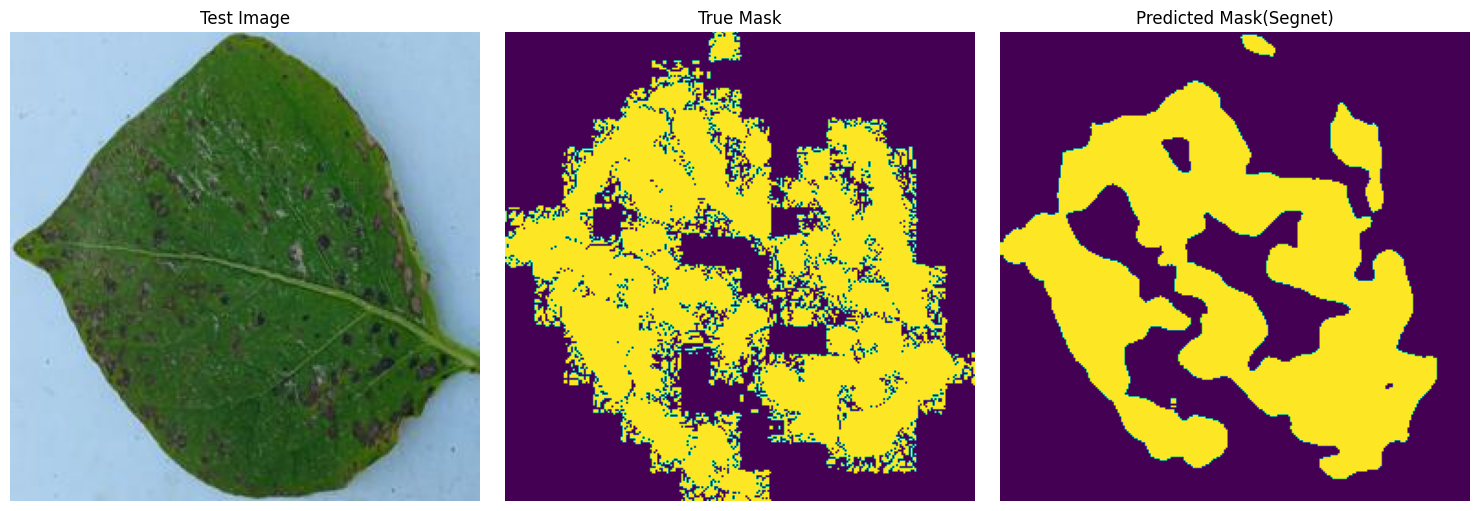

In [19]:
import random

def test_random_image(model, X_test, y_test):
    # Select a random index
    #random_index = random.randint(0, len(X_test) - 1)
    random_index = 35
    
    # Get the test image and true mask
    test_image = X_test[random_index]
    true_mask = y_test[random_index]
    
    # Model prediction (add batch dimension as the model expects it)
    predicted_mask = model.predict(test_image[np.newaxis, ...])[0]
    
    # Threshold the predicted mask (binary segmentation: threshold at 0.5)
    predicted_mask = (predicted_mask > 0.5).astype(np.int32).squeeze()
    
    # Visualize the test image, true mask, and predicted mask
    plt.figure(figsize=(15, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title("Test Image")
    plt.axis("off")
    
    # True Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze())
    plt.title("True Mask")
    plt.axis("off")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title("Predicted Mask(Segnet)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Test a random image
test_random_image(segnet_model, X_test, y_test)